In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gb-credit-default/sample_submission.csv
/kaggle/input/gb-credit-default/train.csv
/kaggle/input/gb-credit-default/test.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
import warnings
warnings.simplefilter('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)
plt.rcParams['figure.figsize'] = (6, 4)

# Загрузка датасетов

In [4]:
TRAIN_DATASET_PATH = '../input/gb-credit-default/train.csv'
TEST_DATASET_PATH = '../input/gb-credit-default/test.csv'
SUBMIT_DATASET_PATH = '../input/gb-credit-default/sample_submission.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)
submit = pd.read_csv(SUBMIT_DATASET_PATH)
df_train.shape, df_test.shape

((7500, 17), (2500, 16))

# Обозначение переменных

In [5]:
target_name = 'Credit Default'
cat_feature_names = [col for col in df_train.drop(target_name, axis=1).columns \
                     if len(df_train[col].unique()) < 16] 
print(f'Категориальные признаки: {cat_feature_names}')
num_feature_names = [col for col in df_train.drop(target_name, axis=1).columns \
                     if col not in cat_feature_names]
print(f'Количественные признаки: {num_feature_names}')
selected_features = cat_feature_names + num_feature_names
print(f'Число признаков - {len(selected_features)}')

Категориальные признаки: ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term']
Количественные признаки: ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
Число признаков - 16


#  Обработка пропусков

Объекты пропусков в тренировочном и тестовом сетах одинаковы, а сами пропуски пропорциональны, предположим, что это обусловлено отсутствием возможности собрать данные.

In [6]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [7]:
df_test.isna().sum()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [8]:
df_train['Years in current job'].fillna(0, inplace=True)
df_test['Years in current job'].fillna(0, inplace=True)
df_train['Bankruptcies'].fillna(0, inplace=True)
df_test['Bankruptcies'].fillna(0, inplace=True)

Из матрицы корреляций делаем вывод, что признак Annual Income коррелирует с признаком Monthly Debt. Заполним пропуски при помощи коэффициента, связывающего значения медиан применимо к вышеуказанным признакам.

Согласно предметной области значение Кредитного рейтинга не превышает 1000. Значения превышающие 1000 явно содержат ошибку. При просмотре данных значений видим, что у них справа добавлен лишний 0. Для исправления ошибки разделим данные значения на 10.

In [9]:
df_test[cat_feature_names].dtypes

Home Ownership                object
Years in current job          object
Tax Liens                    float64
Number of Credit Problems    float64
Bankruptcies                 float64
Purpose                       object
Term                          object
dtype: object

In [10]:
for col in cat_feature_names:
    if df_train[col].dtype == 'float64':
        df_train[col] = df_train[col].astype('int')
        df_test[col] = df_test[col].astype('int')

df_test[cat_feature_names].dtypes

Home Ownership               object
Years in current job         object
Tax Liens                     int64
Number of Credit Problems     int64
Bankruptcies                  int64
Purpose                      object
Term                         object
dtype: object

In [11]:
X = df_train.drop(target_name, axis=1)
y = df_train[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, 
                                                      test_size=0.25, 
                                                      random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((5625, 16), (1875, 16), (5625,), (1875,))

In [12]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    
baseline = catb.CatBoostClassifier(iterations=100, 
                                   nan_mode='Min', 
                                   silent=True, 
                                   random_state=42)
baseline.fit(X_train, y_train, 
             cat_features=cat_feature_names, 
             eval_set=(X_valid, y_valid)
            )

y_train_pred = baseline.predict(X_train)
y_valid_pred = baseline.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      4074
           1       0.86      0.32      0.47      1551

    accuracy                           0.80      5625
   macro avg       0.83      0.65      0.67      5625
weighted avg       0.81      0.80      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1313
           1       0.84      0.31      0.45       562

    accuracy                           0.77      1875
   macro avg       0.80      0.64      0.65      1875
weighted avg       0.79      0.77      0.74      1875



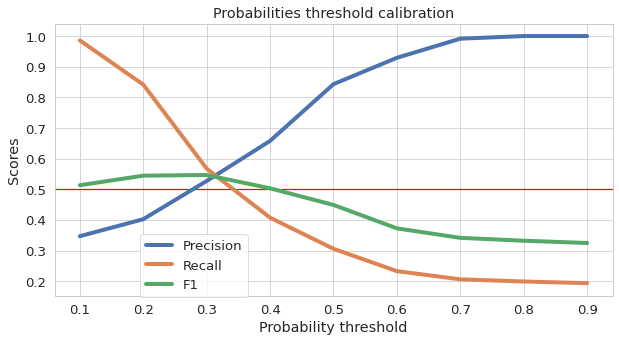

In [13]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
         
    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(111)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25));
    
y_valid_proba = baseline.predict_proba(X_valid)[:, 1]
show_proba_calibration_plots(y_valid_proba, y_valid)

In [14]:
y_valid_pred = np.array(y_valid_proba > 0.31, dtype=int)
get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.98      0.88      4074
           1       0.86      0.32      0.47      1551

    accuracy                           0.80      5625
   macro avg       0.83      0.65      0.67      5625
weighted avg       0.81      0.80      0.76      5625

TEST

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1313
           1       0.54      0.54      0.54       562

    accuracy                           0.72      1875
   macro avg       0.67      0.67      0.67      1875
weighted avg       0.72      0.72      0.72      1875



In [15]:
baseline.fit(X, y, 
             cat_features=cat_feature_names)

y_test_pred = baseline.predict_proba(df_test)[:, 1]
y_test_pred = np.array(y_test_pred > 0.31, dtype=int)

submit['Credit Default'] = y_test_pred
submit.to_csv('baseline_catboost_predictions.csv', index=False)